## Grid simulations mini-project
#### Author: Hannah Sheahan
#### Date: 11/07/2019

#### There are two questions to answer here in this mini-project:
##### 1. Can you get 6-fold modulations in aggregate signal by making randomly directed traversals across a square environment if the underlying neural representation of that space is 6-fold symmetric, just by stacking layers of representations of different scales (according to the known scale difference between them) and with some relative phases between each grid layer.
##### 2. How might a 2D/4-fold symmetric structure emerge from a 6-fold grid structure? If 6-fold grid structure does exist, how do people say that they factorised representation into 2 axes? The issue with grid cell patterns (6 fold) is that they dont factorise into 2 dimensions. So how does that transformation/computation take place? This is relevant theory both for the Constantinescu paper and the odor paper.

##### 3. What if noise is not symmetric in 2D? i.e. y- and x- gaussian noise is assymetric. There is no obvious reason which way around this should go in 2D cases, but I wonder about what this might do to the inferred lattice just based off of the traversal fMRI literature. Could this give rise to a 6-fold looking lattice when really there is a 4-fold one?

In [1]:
import gridHelperFunctions as gf
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import optimize
from scipy import signal
import sklearn
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
import math
import sys
import time
import random
%matplotlib inline

## 1.  Create a basic initial layer grid simulator
#### Use a coding scheme made up from gaussians with independent noise and spacing variables, i.e. with variables for:
###### - spacing between them
###### - noise in each gaussian
###### - angle of code orientation
###### - phase anchor

##### Note: defining sinusoids over odd and even rows will not work, as you will end up stretching the grid in the y-axis

Example grids: hex, square, rectangular


/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


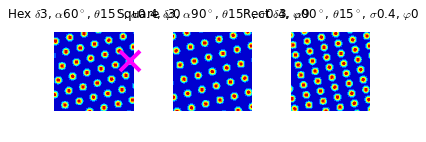

In [2]:
# Free parameters
gridxspacing = 3
noise = 0.4
angle = 15                      # anti-clockwise rotation
phase = 0                       # distance from centre of square in x-dim
resolution = 100                 # number of points on x-dim
gridrange = [-8, 8]
plotrange = [-10, 10]
coordMethod = 1
#-----------------------
print("Example grids: hex, square, rectangular")
# Create a hex grid
#f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
x,y,z = gf.createHexGrid(gridxspacing, noise, angle, phase, resolution, gridrange, plotrange, coordMethod) 
gf.plotGrid(ax1, x, y, z, plotrange, "Hex", False, gridxspacing, 60, phase, angle, noise)  # beware that if the gridxspacing maxes out this descriptor will be incorrect for the real grid.
ax1.set_aspect('equal', adjustable='box')

# choose a random max point on the grid (empirical max, not based on known centres)
xloc, yloc = gf.findMaxPointCentre(z)
ax1.plot(x[xloc][yloc], y[xloc][yloc], marker='x',color='magenta', markersize=20, markeredgewidth=4)

# Create a square lattice for comparison
xs,ys,zs = gf.createSquareGrid(gridxspacing, noise, angle, phase, resolution, gridrange, plotrange)
gf.plotGrid(ax2, xs, ys, zs, plotrange, "Square", False, gridxspacing, 90, phase, angle, noise) 
ax2.set_aspect('equal', adjustable='box')

# Create a rectangular lattice for comparison
gridyspacing = gridxspacing*0.7
xr,yr,zr = gf.createRectGrid(gridxspacing, gridyspacing, noise, angle, phase, resolution, gridrange, plotrange)
gf.plotGrid(ax3, xr, yr, zr, plotrange, "Rect", False, gridxspacing, 90, phase, angle, noise) 
ax3.set_aspect('equal', adjustable='box')

# Create a lattice with a random axis A and axis B spacing and angle alpha
#alpha = random.uniform(0,90)
#xran,yran,zran = gf.createGrid(random.uniform(1,10), random.uniform(1,10), random.uniform(0,90), random.uniform(0,7), alpha,  phase, resolution, gridrange, plotrange)
#gf.plotGrid(ax4, xran, yran, zran, plotrange, "Rect", False, gridxspacing,  alpha, phase, angle, noise) 
#ax4.set_aspect('equal', adjustable='box')
#ax4.set_title("Random parameters")

#-------------------------
# This is how you stack grids on top of each other
#_,_,z2 = gf.createHexGrid(gridxspacing*2, noise*2, angle, phase, resolution, gridrange, plotrange, coordMethod)
#_,_,z3 = gf.createHexGrid(gridxspacing*3, noise*5, 0, phase, resolution, gridrange, plotrange, coordMethod)
#gf.plotGrid(plt.gca(), x, y, z+z2+z3, plotrange, "Stacked lattices", False)


## 2. Write a function that evaluates the X-foldness of a given grid
##### So that we can see a plot of the evidence for a given grid being 6-fold v 5-fold v 4-fold etc

#### Symmetry Notes:
###### - Formally, each axis of symmetry requires that f(t) = f(-t), for values t along the axis T.
###### - If you have a perfect lattice the algorithm for n-fold symmetry is: 1) choose a random point, 2) then expand a radius from that point outwards until it finds the centre of the next closest point (by evaluating when heat starts going in negative gradient after being +ve gradient),3) then finds the line connecting those two, 4) then find the next most closest point that doesnt fall along the same axis. This defines your two grid axes. The distance between them and the angle between them define the form of the lattice. 5) ... Or just take the first line of radius R and rotate it 360 degrees then plot the generated heatmap. BUT! choosing your second point causes issues when you have a multi-scale or low resolution/noisy grid, since your second point as evaluated by the gradient might be a small bubble when the overwhelming pattern is big strong bubbles that are far apart.

#### Lattice-fitting Notes: 
###### - Having written a function to fit lattice parameters to generated data, it turns out lattice fitting is really hard numerical optimisation problem!
###### - Increasing the scale of z helps a bit because numerical optimisation performs poorly on v small or v large numbers and ours were pretty small; Even fitting to a single parameter (grid spacing for 1 axis) produces a crazy bumpy fitting surface for even just one parameter! Some other parameters are easier like orientation or phase.
###### -Since the fitting surface is mega bumpy, instead define specific n-fold models with all params fixed just different specified n-fold, and see which one of these produces the best fit (argmin SSE).



In [3]:
# Experiment with fitting different lattice parameters in isolation to data, to see how good lattice-classification is numerically
fitModel = False
if fitModel:
    maxiter = 2
    fitwhichparams = [0,0,0,0,0,1]
    initparams = [3, 3, 60, 0.4, 15, 3]
    fitted_params, fitted_SSE = gf.fitLattice(maxiter, z, fitwhichparams, initparams)

    #--------------------
    # See what the best fitting parameters were
    opt_iter = np.nanargmin(fitted_SSE)
    opt_params = fitted_params[opt_iter][:]
    str_params = ''.join("{:.2f}  ".format(e) for e in opt_params)
    print("Best fitting parameters: "+ str_params)
    
    # View how smooth the fitting surface was for the parameter
    ax = gf.visualizeParameterFit(5, fitted_params, fitted_SSE)
    
    # Plot the grids generated from the model next to data
    ax = gf.visualCompareGridModels(x, y, z, [opt_params], gridrange, plotrange)
        

In [4]:
# Simply the fitting by comparing a set of specific n-fold symmetry models (given A/B spacings, gaussian noise)
fitModel = False
if fitModel:
    maxiter = 3
    folds = [4, 6, 7]   # the candidate n-fold symmetry models we will compare
    otherparams = [3, 3, 0, 0.4, 0, 0]
    nfoldParams, nfoldSSE = gf.fitNFoldModels(maxiter, folds, z, otherparams, False)

    # Plot the grids generated from the model next to data
    ax = gf.visualCompareGridModels(x, y, z, nfoldParams, gridrange, plotrange)
    ax[0].set_title("Actual data")
    for i in range(len(folds)):
        ax[i+1].set_title("Fitted model: {:}-fold".format(folds[i]))


## 3. Have an agent make random traversals across a given square grid
##### of approx uniformly distributed distances and angles,  (i.e. sample the trajectories uniform randomly from a distance v angle space).

##### - plot the aggregate 'highs' traversed across the grid as a function of angle of movement

##### Note: uniform random start and end positions on a square give uniform sampling distribution of traj orientation, but shifted ~gaussian distribution of trajectory length (which will mean uneven sampling of distance, but importantly will give non-uniform sampling distance x angle covariance). We need to have uniform p(dist|angle) in order to do this fairly because otherwise aggregate activity will always be greater in angles corresponding to the diagonals. 

##### - So that means sampling these trajectories over a circle is the fair way to do it to get uniform p(dist|angle). Do this second. ... actually maybe its ok so long as we normalise the activity on a given trajectory over the number of cells hit?

/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


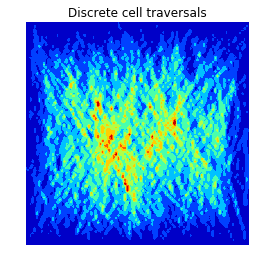

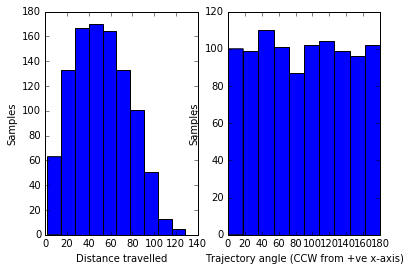

In [8]:
# Sample trajectories over a square...

# sample starting and finishing positions evenly across the square
# then plot the resulting distribution of distances and angles of traversal
# then perform those traversals and record the net activity summed along that path

# remember that you will need to normalize the aggregate activity over the number of x,y cells actually hit on a trajectory, because this will always be more closer to the cardinal axes than to 45 deg


# Note: uniform random start and end point sampling on a square produces non-uniform distribution of trajectory lengths (but uniform dist of traj angles)
numSamples = 1000


ref_vector = [1, 0]                    # measuring angles CCW from +ve x-axis
distances  = gf.nanArray((numSamples,1))
angles  = gf.nanArray((numSamples,1))
netActivity = gf.nanArray((numSamples,1))
numCells = gf.nanArray((numSamples,1))
drawing = np.copy(z)
drawing.fill(0)

for sample in range(numSamples):
    sample_start = np.asarray([ random.randrange(0,resolution), random.randrange(0,resolution) ]) # random index on grid
    sample_end   = np.asarray([ random.randrange(0,resolution), random.randrange(0,resolution) ])
    sample_vect  = sample_end - sample_start
    vect_angle   =  math.degrees(gf.angle_between(ref_vector, sample_vect))
    vect_dist    = np.linalg.norm(sample_vect)

    # Use Bresenham's line algorithm to determine which discrete cells of z are traversed on this path
    aggrActivity, nCellsTraversed, nextline = gf.aggregateBresenhamLine(z, sample_start, sample_end)
    
    distances[sample] = vect_dist
    angles[sample] = vect_angle
    netActivity[sample] = aggrActivity
    numCells[sample] = nCellsTraversed
    drawing += nextline

plt.figure()
plt.contourf(x,y,drawing)
axes = plt.gca()
axes.set_aspect('equal', adjustable='box')
axes.axis('off')
axes.set_title('Discrete cell traversals')
   
plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(distances)
ax1.set_xlabel('Distance travelled')
ax1.set_ylabel('Samples')

ax2.hist(angles)
ax2.set_xlabel('Trajectory angle (CCW from +ve x-axis)')
ax2.set_ylabel('Samples')

#------------------------------------

